# Cat and Dog Classification using Convolutional Neural Networks

# Data Preparation

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

## Zip Extraction

In [ ]:
!unzip train.zip

In [ ]:
!unzip test1.zip

## Create Dataframe

In [2]:
filenames = os.listdir('train')

categories = []
for f_name in filenames:
    if 'dog' in f_name:
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

test_filenames = os.listdir('test1')
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [3]:
df['category'] = df['category'].replace({0:'cat',1:'dog'})
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]

# Modelling

## Custom CNN Model

In [27]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width,Image_Height)
Image_Channels = 3

### Data Preparation

In [28]:
batch_size = 128

In [29]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    'train/',
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=Image_Size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df, 
                                                              'train/', 
                                                              x_col='filename',
                                                              y_col='category',
                                                              target_size=Image_Size,
                                                              class_mode='categorical',
                                                              batch_size=batch_size,
                                                              shuffle=True)

test_generator = validation_datagen.flow_from_dataframe(test_df,
                                                        'test1/',
                                                        x_col='filename',
                                                        y_col=None,
                                                        target_size=Image_Size,
                                                        class_mode=None,
                                                        shuffle=False,
                                                        batch_size=batch_size)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Training

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [31]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels), padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 256)      

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
earlystop = EarlyStopping(patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [34]:
epochs = 30
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=total_validate//batch_size,
                    steps_per_epoch=total_train//batch_size,
                    callbacks=callbacks)

Epoch 1/30
156/156 [==============================] - 280s 2s/step - loss: 0.7351 - accuracy: 0.5495 - val_loss: 0.6305 - val_accuracy: 0.6611
Epoch 2/30
156/156 [==============================] - 275s 2s/step - loss: 0.6147 - accuracy: 0.6684 - val_loss: 0.5278 - val_accuracy: 0.7376
Epoch 3/30
156/156 [==============================] - 275s 2s/step - loss: 0.5431 - accuracy: 0.7313 - val_loss: 0.4942 - val_accuracy: 0.7628
Epoch 4/30
156/156 [==============================] - 276s 2s/step - loss: 0.4979 - accuracy: 0.7582 - val_loss: 0.4201 - val_accuracy: 0.8139
Epoch 5/30
156/156 [==============================] - 276s 2s/step - loss: 0.4420 - accuracy: 0.7954 - val_loss: 0.4143 - val_accuracy: 0.8125
Epoch 6/30
156/156 [==============================] - 276s 2s/step - loss: 0.4044 - accuracy: 0.8143 - val_loss: 0.3558 - val_accuracy: 0.8448
Epoch 7/30
156/156 [==============================] - 276s 2s/step - loss: 0.3798 - accuracy: 0.8319 - val_loss: 0.3221 - val_accuracy: 0.8610

In [41]:
model.save('model.h5')

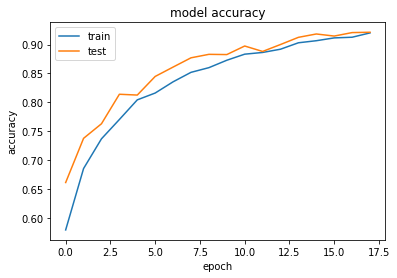

In [35]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

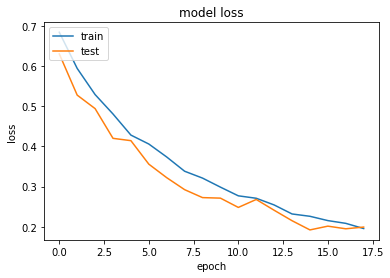

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing

In [37]:
predict = model.predict(test_generator)

In [38]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

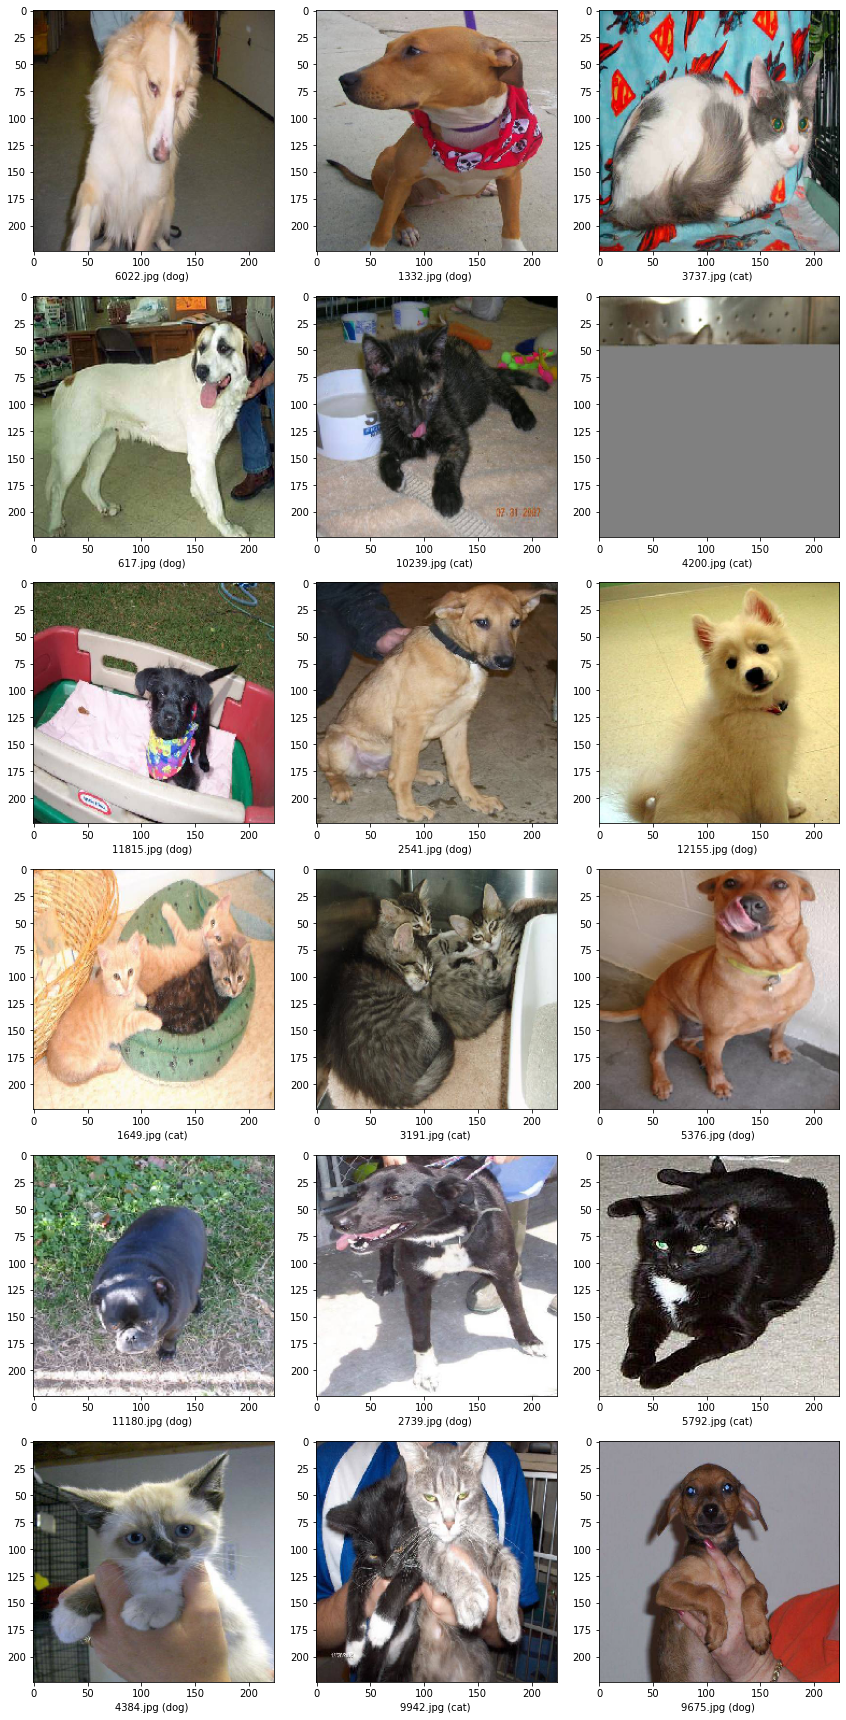

In [39]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('test1/' + filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f'{filename} ({category}) ')
plt.tight_layout()
plt.show()

## VGG16 Model

In [14]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width,Image_Height)
Image_Channels = 3
batch_size = 32

### Data Preparation

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [15]:
train_datagen = ImageDataGenerator(rotation_range=10,                                                                
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function=preprocess_input)

X_train = train_datagen.flow_from_dataframe(train_df,
                                            'train/',
                                            x_col='filename',
                                            y_col='category',
                                            target_size=Image_Size,
                                            class_mode='categorical',
                                            shuffle=True,
                                            batch_size=batch_size)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
X_validation = validation_datagen.flow_from_dataframe(validate_df,
                                                      'train/',
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=Image_Size,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      batch_size=batch_size)
X_test = validation_datagen.flow_from_dataframe(test_df,
                                                'test1/',
                                                x_col='filename',
                                                y_col=None,
                                                target_size=Image_Size,
                                                class_mode=None,
                                                shuffle=False,
                                                batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Training

In [16]:
epoch = 20
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

In [17]:
earlystop = EarlyStopping(patience=3)
    
lr_callback = LearningRateScheduler(lrfn, verbose=True)

callbacks = [earlystop, lr_callback]

In [18]:
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(Image_Width, Image_Height, Image_Channels))

model_vgg16.trainable = False

In [19]:
model = Sequential([model_vgg16,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'),
                    Dropout(0.4),
                    Dense(2, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 15,242,050
Trainable params: 527,362
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
optimizer = Adam(1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
history = model.fit(X_train, 
                    epochs=epoch, 
                    callbacks=callbacks, 
                    validation_steps=total_validate//batch_size,
                    steps_per_epoch=total_train//batch_size,
                    validation_data=X_validation)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
625/625 [==============================] - 341s 526ms/step - loss: 3.2544 - accuracy: 0.5289 - val_loss: 3.2647 - val_accuracy: 0.5104
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3e-05.
625/625 [==============================] - 283s 453ms/step - loss: 0.7487 - accuracy: 0.8371 - val_loss: 0.0721 - val_accuracy: 0.9794
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 3e-05.
625/625 [==============================] - 282s 451ms/step - loss: 0.1463 - accuracy: 0.9593 - val_loss: 0.0680 - val_accuracy: 0.9818
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.4200000000000002e-05.
625/625 [==============================] - 278s 444ms/step - loss: 0.1310 - accuracy: 0.9662 - val_loss: 0.0659 - val_accuracy: 0.9832
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 1.9560000000000006e-05.
625/625 [=================

In [22]:
model.save('vgg16.h5')

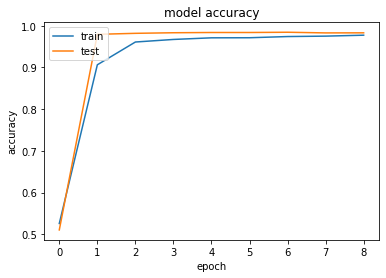

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

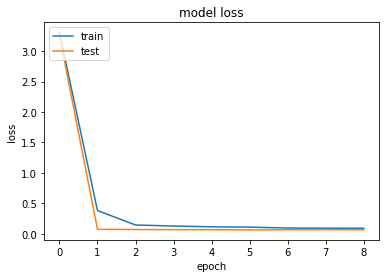

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing

In [25]:
predict = model.predict(X_test)

In [26]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in X_train.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

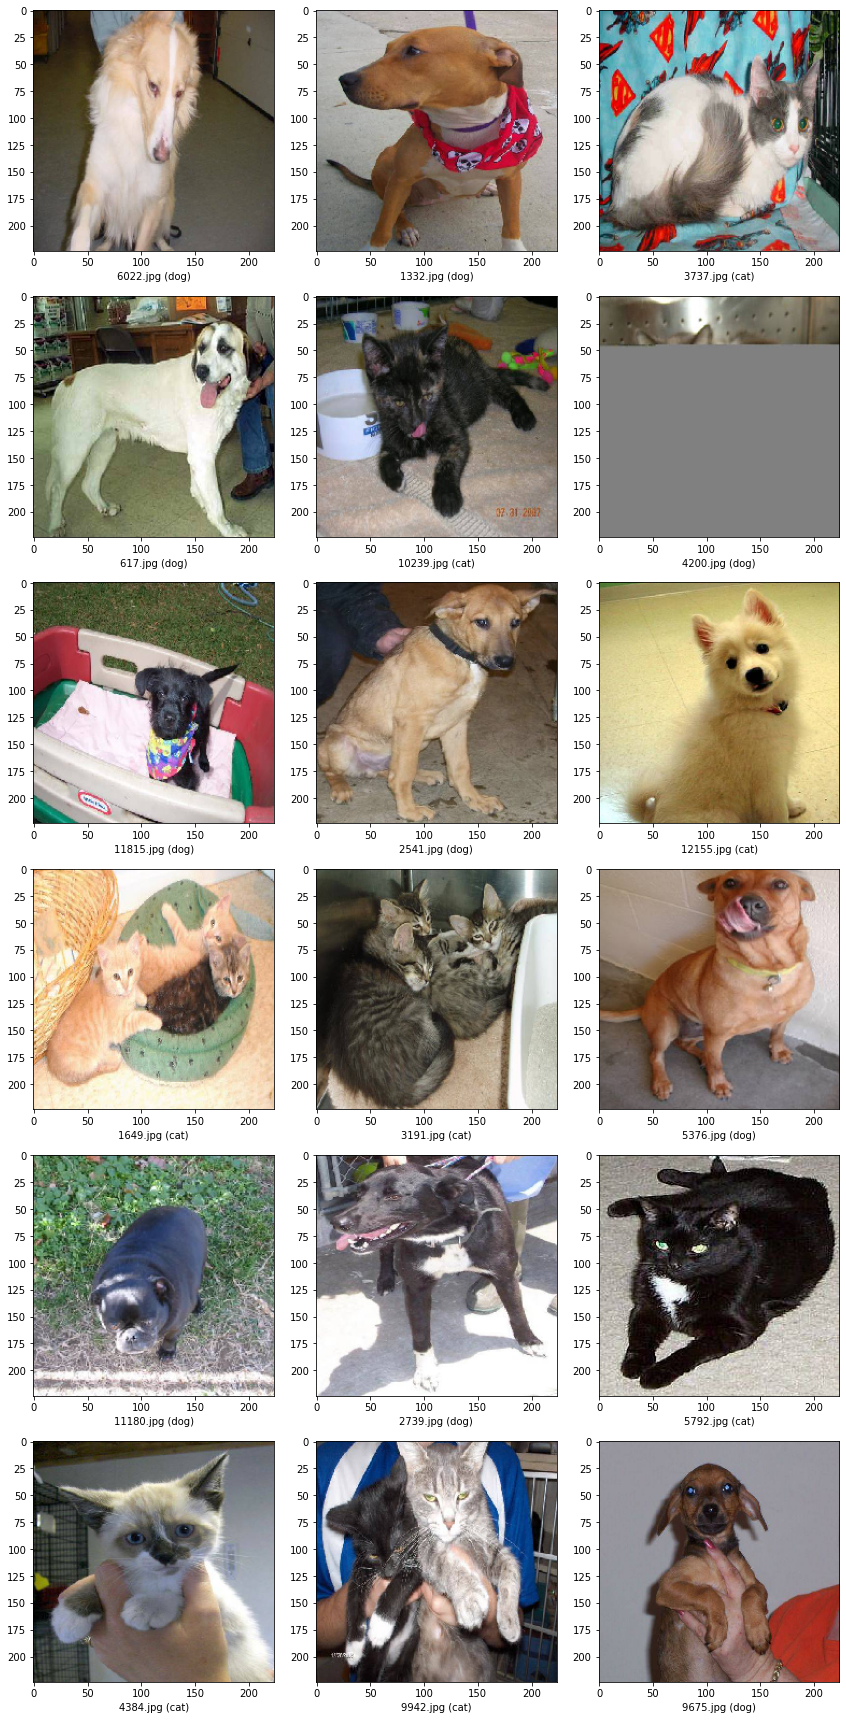

In [27]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('test1/' + filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f'{filename} ({category})')
plt.tight_layout()
plt.show()

## MobileNet V2 Model

In [4]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width,Image_Height)
Image_Channels = 3

### Data Preparation

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [6]:
batch_size = 32

In [8]:
train_datagen = ImageDataGenerator(rotation_range=10,                                                                
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function=preprocess_input)

X_train = train_datagen.flow_from_dataframe(train_df,
                                            'train/',
                                            x_col='filename',
                                            y_col='category',
                                            target_size=Image_Size,
                                            class_mode='categorical',
                                            shuffle=True,
                                            batch_size=batch_size)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
X_validation = validation_datagen.flow_from_dataframe(validate_df,
                                                      'train/',
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=Image_Size,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [9]:
X_test = validation_datagen.flow_from_dataframe(test_df,
                                                'test1/',
                                                x_col='filename',
                                                y_col=None,
                                                target_size=Image_Size,
                                                class_mode=None,
                                                shuffle=False,
                                                batch_size=batch_size)

Found 12500 validated image filenames.


### Training

In [10]:
epoch = 20
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

In [11]:
earlystop = EarlyStopping(patience=3)
    
lr_callback = LearningRateScheduler(lrfn, verbose=True)

callbacks = [earlystop, lr_callback]

In [12]:
model_mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(Image_Width, Image_Height, Image_Channels))

model_mobilenet_v2.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
model = Sequential([model_mobilenet_v2,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'),
                    Dropout(0.4),
                    Dense(2, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
optimizer = Adam(1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
history = model.fit(X_train, 
                    epochs=epoch, 
                    callbacks=callbacks, 
                    validation_steps=total_validate//batch_size,
                    steps_per_epoch=total_train//batch_size,
                    validation_data=X_validation)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
625/625 [==============================] - 317s 501ms/step - loss: 1.1085 - accuracy: 0.4781 - val_loss: 0.9925 - val_accuracy: 0.4958
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3e-05.
625/625 [==============================] - 262s 420ms/step - loss: 0.2211 - accuracy: 0.9116 - val_loss: 0.0571 - val_accuracy: 0.9814
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 3e-05.
625/625 [==============================] - 263s 420ms/step - loss: 0.0586 - accuracy: 0.9797 - val_loss: 0.0490 - val_accuracy: 0.9824
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.4200000000000002e-05.
625/625 [==============================] - 263s 421ms/step - loss: 0.0459 - accuracy: 0.9826 - val_loss: 0.0495 - val_accuracy: 0.9820
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 1.9560000000000006e-05.
625/625 [=================

In [23]:
model.save('mobilenet_v2_global_average_pooling.h5')

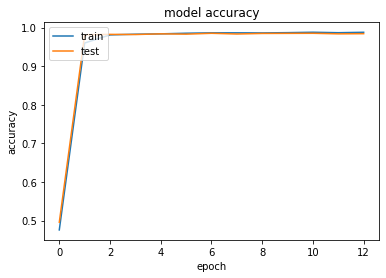

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

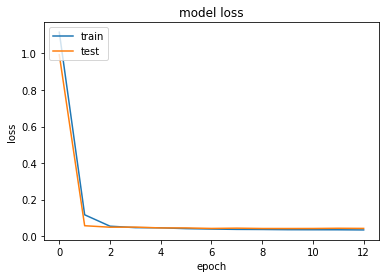

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing

In [18]:
predict = model.predict(X_test)

In [19]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in X_train.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

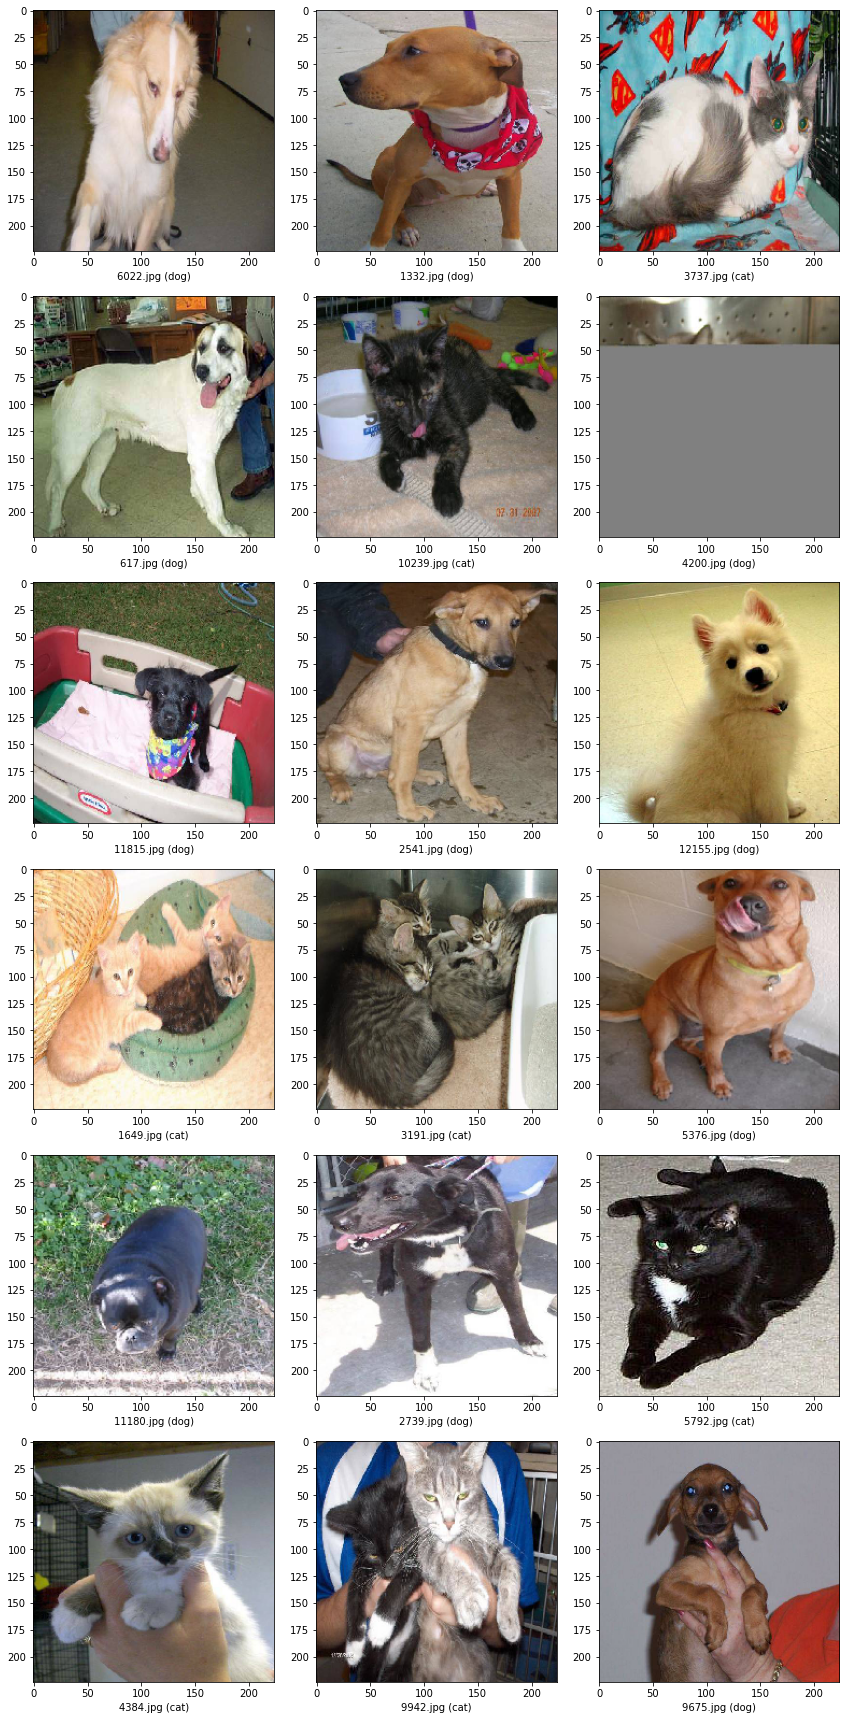

In [22]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('test1/' + filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f'{filename} ({category})')
plt.tight_layout()
plt.show()

## ResNet50 Model

In [4]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width,Image_Height)
Image_Channels = 3

### Data Preparation

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [9]:
batch_size = 32

In [10]:
train_datagen = ImageDataGenerator(rotation_range=10,                                                                
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function=preprocess_input)

X_train = train_datagen.flow_from_dataframe(train_df,
                                            'train/',
                                            x_col='filename',
                                            y_col='category',
                                            target_size=Image_Size,
                                            class_mode='categorical',
                                            shuffle=True,
                                            batch_size=batch_size)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
X_validation = validation_datagen.flow_from_dataframe(validate_df,
                                                      'train/',
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=Image_Size,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      batch_size=batch_size)
X_test = validation_datagen.flow_from_dataframe(test_df,
                                                'test1/',
                                                x_col='filename',
                                                y_col=None,
                                                target_size=Image_Size,
                                                class_mode=None,
                                                shuffle=False,
                                                batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Training

In [11]:
epoch = 20
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

In [12]:
earlystop = EarlyStopping(patience=3)
    
lr_callback = LearningRateScheduler(lrfn, verbose=True)

callbacks = [earlystop, lr_callback]

In [13]:
model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(Image_Width, Image_Height, Image_Channels))

model_resnet.trainable = False

94773248/94765736 [==============================] - 4s 0us/step


In [14]:
model = Sequential([model_resnet,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'),
                    Dropout(0.4),
                    Dense(2, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 25,687,938
Trainable params: 2,100,226
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
optimizer = Adam(1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, 
                    epochs=epoch, 
                    callbacks=callbacks, 
                    validation_steps=total_validate//batch_size,
                    steps_per_epoch=total_train//batch_size,
                    validation_data=X_validation)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
625/625 [==============================] - 335s 520ms/step - loss: 0.9054 - accuracy: 0.5152 - val_loss: 0.8071 - val_accuracy: 0.5032
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 3e-05.
625/625 [==============================] - 269s 431ms/step - loss: 0.1859 - accuracy: 0.9208 - val_loss: 0.0378 - val_accuracy: 0.9876
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 3e-05.
625/625 [==============================] - 278s 445ms/step - loss: 0.0520 - accuracy: 0.9815 - val_loss: 0.0329 - val_accuracy: 0.9884
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.4200000000000002e-05.
625/625 [==============================] - 270s 431ms/step - loss: 0.0380 - accuracy: 0.9863 - val_loss: 0.0324 - val_accuracy: 0.9886
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 1.9560000000000006e-05.
625/625 [=================

In [ ]:
model.save('model_resnet50_global_average_pooling.h5')

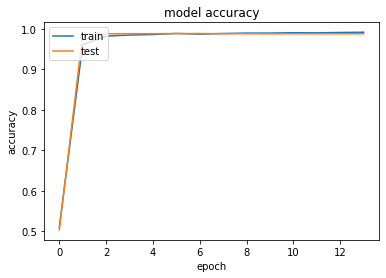

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

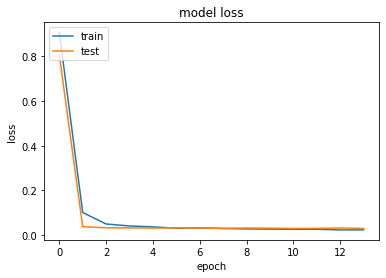

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Testing

In [ ]:
predict = model.predict(X_test)

In [25]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in X_train.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

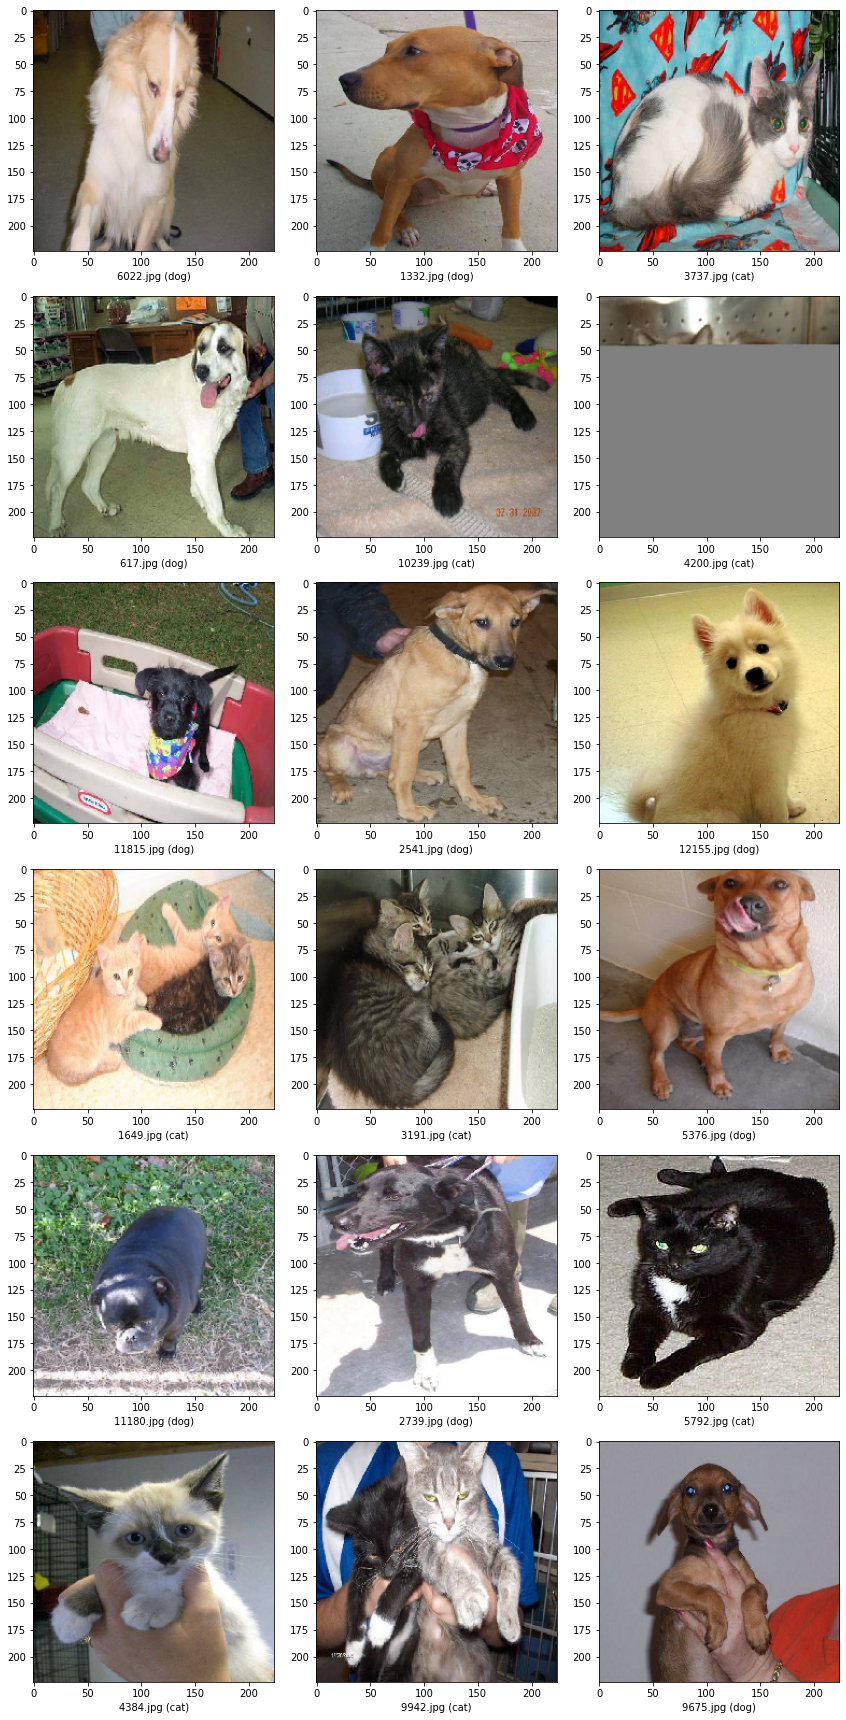

In [26]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('test1/' + filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f'{filename} ({category})')
plt.tight_layout()
plt.show()